In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(0)
device = torch.device('cpu')

In [7]:
hamiltorch.__version__

'0.4.0.dev1'

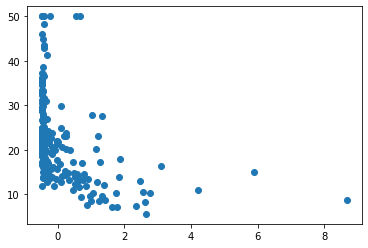

In [8]:
from sklearn.datasets import load_boston
import numpy as np

data = load_boston()

x_ = data['data']
y_ = data['target']
N_tr = int(x_.shape[0] * 0.5)
N_val = x_.shape[0] - N_tr
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = (x_val-x_m)/ x_s

D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
plt.scatter(x_train.numpy()[:,0],y_train.numpy())
    
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [9]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.is_available():
#     print(torch.cuda.get_device_name(0))

device=torch.device('cpu')

class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D_in, num_nodes).train(False)
        self.fc2 = nn.Linear(num_nodes, num_nodes).train(False)
        self.fc3 = nn.Linear(num_nodes, 1).train(False)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def load_sampled_weights(self, l_1_w, l_1_b, l_2_w, l_2_b, l_3_w, l_3_b):
        self.fc1.weight = nn.Parameter(l_1_w.reshape(self.fc1.weight.shape))
        self.fc1.bias = nn.Parameter(l_1_b.reshape(self.fc1.bias.shape))
        self.fc2.weight = nn.Parameter(l_2_w.reshape(self.fc2.weight.shape))
        self.fc2.bias = nn.Parameter(l_2_b.reshape(self.fc2.bias.shape))
        self.fc3.weight = nn.Parameter(l_3_w.reshape(self.fc3.weight.shape))
        self.fc3.bias = nn.Parameter(l_3_b.reshape(self.fc3.bias.shape))

num_nodes = 10
alpha = 1.
beta = .2
ELBO_BETA = 1.
net = Net(num_nodes=num_nodes)

# MF-VI Approx

In [10]:
from models.BNNs.pyroVIBNN_BOSTON import BayesianNeuralNetwork
from pyro.infer.autoguide import AutoDiagonalNormal
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
import pyro
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm
from tqdm.notebook import trange

In [11]:
class Model_Full(PyroModule):
    def __init__(self, h1=num_nodes, h2=num_nodes):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](13, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, 13]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, 1./beta), obs=y)
        return mu

In [12]:
class Model_Fixed_L1(PyroModule):
    def __init__(self, l1_weight, l1_bias, h1=num_nodes, h2=num_nodes):
        super().__init__()
        self.fc1 = nn.Linear(13, h1).train(False)
        self.fc1.weight = nn.Parameter(l1_weight.reshape(self.fc1.weight.shape), requires_grad=False)
        self.fc1.bias = nn.Parameter(l1_bias.reshape(self.fc1.bias.shape), requires_grad=False)
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, 1./beta), obs=y)
        return mu

In [13]:
class Model_Fixed_L2(PyroModule):
    def __init__(self, l1_weight, l1_bias, l2_weight, l2_bias, h1=num_nodes, h2=num_nodes):
        super().__init__()
        self.fc1 = nn.Linear(13, h1).train(False)
        self.fc1.weight = nn.Parameter(l1_weight.reshape(self.fc1.weight.shape), requires_grad=False)
        self.fc1.bias = nn.Parameter(l1_bias.reshape(self.fc1.bias.shape), requires_grad=False)
        self.fc2 = nn.Linear(h1, h2).train(False)
        self.fc2.weight = nn.Parameter(l2_weight.reshape(self.fc2.weight.shape), requires_grad=False)
        self.fc2.bias = nn.Parameter(l2_bias.reshape(self.fc2.bias.shape), requires_grad=False)
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, 1./beta), obs=y)
        return mu

In [14]:
def make_empirical_gmm(preds):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Normal(loc=preds.squeeze().permute(1, 0), scale=beta ** -0.5)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

In [15]:
# create models
model = Model_Full()
guide = AutoDiagonalNormal(model)

In [16]:
from pyro.infer import SVI, TraceMeanField_ELBO


optimizer = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': {'lr': 5e-2}, 'gamma': 0.9})

# scheduler = pyro.optim.ExponentialLR({'optimizer': adam, 'gamma': 0.1})
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO())

num_iterations = 5000
pyro.clear_param_store()
pbar = trange(num_iterations)
losses = []
for j in pbar:
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train)
    losses.append(loss)
    pbar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))
    if j % 1000 == 0:
        scheduler.step()
guide.requires_grad_(False)

  0%|          | 0/5000 [00:00<?, ?it/s]

AutoDiagonalNormal()

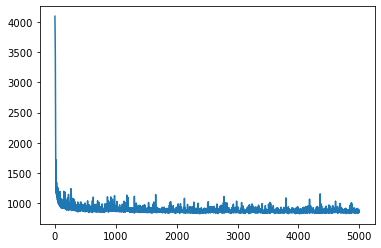

In [17]:
plt.plot(losses)

In [18]:
params = []
for name, value in pyro.get_param_store().items():
    params.append(pyro.param(name))

In [19]:
mean, stds = params

In [20]:
model_loss = 'regression'

# Effect of tau
tau = alpha # Prior Precision
tau_out = beta # Output Precision

tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

variational_posterior = D.MultivariateNormal(loc=mean, covariance_matrix=torch.diag(stds ** 2))

variational_samples = variational_posterior.sample((1000,))

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/pyro/distributions/torch_patch.py:81: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  return torch.stack([v.symeig(eigenvectors=False)[0][:1] > 0.0


In [21]:
prior = D.MultivariateNormal(loc=torch.zeros_like(variational_posterior.mean), covariance_matrix = 1./alpha * torch.eye(variational_posterior.mean.shape[-1]))
D.kl_divergence(variational_posterior, prior)

tensor(117.6717)

In [22]:
from pyro.infer import Predictive
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=(("obs",)))

In [23]:
emp_bnn = make_empirical_gmm(predictive(x_val)['obs'])

emp_bnn.log_prob(y_val).sum()

tensor(-752.5527)

In [24]:
((predictive(x_val)['obs'].mean(0) - y_val) ** 2).sqrt().mean()

tensor(3.3266)

In [25]:
l1_mu, l1_std = mean[:num_nodes * (13+1)], stds[:num_nodes * (13+1)]

In [26]:
l1_post = D.MultivariateNormal(loc=l1_mu, covariance_matrix=torch.diag(l1_std ** 2))

In [27]:
l1_sample = l1_post.sample()
l1_w_sample = l1_sample[:num_nodes * 13]
l1_b_sample = l1_sample[num_nodes * 13: num_nodes * (13+1)]

In [28]:
model.fc1.weight.flatten().shape, l1_w_sample.shape

(torch.Size([130]), torch.Size([130]))

In [29]:
model.fc1.bias.flatten().shape, l1_b_sample.shape

(torch.Size([10]), torch.Size([10]))

In [30]:
conditioned_model_l1 = Model_Fixed_L1(l1_w_sample, l1_b_sample)

In [31]:
l1_guide = AutoDiagonalNormal(conditioned_model_l1)

In [32]:
optimizer = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': {'lr': 5e-2}, 'gamma': 0.9})


svi = SVI(conditioned_model_l1, l1_guide, scheduler, loss=TraceMeanField_ELBO())
num_iterations = 5000
pyro.clear_param_store()
pbar = trange(num_iterations)
losses = []
for j in pbar:
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train)
    losses.append(loss)
    pbar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))
    if j % 1000 == 0:
        scheduler.step()
guide.requires_grad_(False)

  0%|          | 0/5000 [00:00<?, ?it/s]

AutoDiagonalNormal()

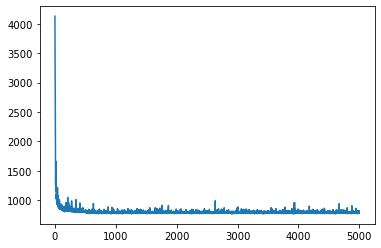

In [33]:
plt.plot(losses)

In [34]:
predictive = Predictive(conditioned_model_l1, guide=l1_guide, num_samples=1000,
                        return_sites=(("obs",)))

In [35]:
emp_bnn = make_empirical_gmm(predictive(x_val)['obs'])

emp_bnn.log_prob(y_val).sum()

tensor(-730.6937)

In [36]:
((predictive(x_val)['obs'].mean(0) - y_val) ** 2).sqrt().mean()

tensor(3.0254)

In [37]:
params = []
for name, value in pyro.get_param_store().items():
    params.append(pyro.param(name))

In [38]:
mean, stds = params

In [39]:
model.fc2.weight.flatten().shape, mean[:num_nodes * num_nodes].shape

(torch.Size([100]), torch.Size([100]))

In [40]:
l2_mu, l2_std = mean[:num_nodes * (num_nodes+1)], stds[:num_nodes * (num_nodes+1)]

In [41]:
l2_post = D.MultivariateNormal(loc=l2_mu, covariance_matrix=torch.diag(l2_std ** 2))

In [42]:
l2_sample = l2_post.sample()
l2_w_sample = l2_sample[:num_nodes * (num_nodes+0)]
l2_b_sample = l2_sample[num_nodes * (num_nodes+0): num_nodes * (num_nodes+1)]

In [43]:
model.fc2.weight.flatten().shape, l2_w_sample.shape

(torch.Size([100]), torch.Size([100]))

In [44]:
model.fc2.bias.flatten().shape, l2_b_sample.shape

(torch.Size([10]), torch.Size([10]))

In [45]:
conditioned_model_l2 = Model_Fixed_L2(l1_w_sample, l1_b_sample, l2_w_sample, l2_b_sample)

In [46]:
l2_guide = AutoDiagonalNormal(conditioned_model_l2)

In [47]:
optimizer = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': {'lr': 5e-2}, 'gamma': 0.9})


svi = SVI(conditioned_model_l2, l2_guide, scheduler, loss=TraceMeanField_ELBO())
num_iterations = 5000
pyro.clear_param_store()
pbar = trange(num_iterations)
losses = []
for j in pbar:
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train)
    losses.append(loss)
    pbar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))
    if j % 1000 == 0:
        scheduler.step()
guide.requires_grad_(False)

  0%|          | 0/5000 [00:00<?, ?it/s]

AutoDiagonalNormal()

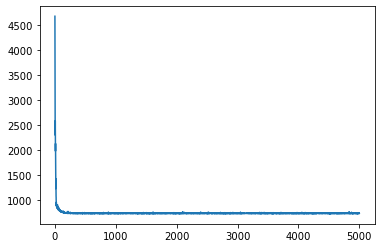

In [48]:
plt.plot(losses)

In [49]:
predictive = Predictive(conditioned_model_l2, guide=l2_guide, num_samples=1000,
                        return_sites=(("obs",)))

In [50]:
emp_bnn = make_empirical_gmm(predictive(x_val)['obs'])

emp_bnn.log_prob(y_val).sum()

tensor(-720.7634)

In [51]:
((predictive(x_val)['obs'].mean(0) - y_val) ** 2).sqrt().mean()

tensor(2.7740)

In [52]:
params = []
for name, value in pyro.get_param_store().items():
    params.append(pyro.param(name))

In [53]:
mean, stds = params

In [54]:
model.fc3.weight.flatten().shape, mean[:num_nodes * (1)].shape

(torch.Size([10]), torch.Size([10]))

In [55]:
l3_mu, l3_std = mean[:num_nodes * (1+1)], stds[:num_nodes * (1+1)]

In [56]:
l3_post = D.MultivariateNormal(loc=l3_mu, covariance_matrix=torch.diag(l3_std ** 2))

In [57]:
l3_sample = l3_post.sample()
l3_w_sample = l3_sample[:num_nodes * 1]
l3_b_sample = l3_sample[num_nodes * 1: (num_nodes+1)* 1]

In [58]:
model.fc3.weight.flatten().shape, l3_w_sample.shape

(torch.Size([10]), torch.Size([10]))

In [59]:
model.fc3.bias.flatten().shape, l3_b_sample.shape

(torch.Size([1]), torch.Size([1]))

In [60]:
l3_sample[num_nodes * (1+0): num_nodes * (1+1)]

tensor([1.6837])

In [61]:
net = Net(num_nodes)
net.load_sampled_weights(l1_w_sample, l1_b_sample, l2_w_sample, l2_b_sample, l3_w_sample, l3_b_sample)

In [62]:
((net(x_val).flatten() - y_val)**2).sqrt().mean()

tensor(2.8384, grad_fn=<MeanBackward0>)